In [1]:
# general imports
import tensorflow as tf
import os
import keras
from pickle import load
from math import ceil
from numpy.random import choice
import matplotlib.pyplot as plt

# model imports
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout, Embedding, Add, LayerNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
from keras.losses import SparseCategoricalCrossentropy
from keras.regularizers import L2
from keras.utils import plot_model

# custom function imports
from functions.dataset_loading import load_flicker8k_split
from functions.text_processing import create_vocab_mappings
from functions.image_processing import display_image
from functions.training import data_generator
from functions.model_evaluation import generate_and_evaluate_caption, generate_captions, evaluate_captions

from keras.mixed_precision import set_global_policy
set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SEQ_LENGTH = 20
HIDDEN_DIM = 1024
PRED_DIM = 512
REG_FACTOR = 0.000001
LEARNING_RATE = 0.0001
DROPOUT = 0.2
BATCH_SIZE = 512
EVAL_BATCH_SIZE = 1024

In [3]:
FLICKER = 'preprocessed_data/flicker8k/'

with open(FLICKER + 'caption_map.pkl', 'rb') as file:
    flicker_caption_map = load(file)
    
with open(FLICKER + 'avg_feature_map.pkl', 'rb') as file:
    flicker_feature_map = load(file)
    
flicker_train_images, flicker_val_images, flicker_test_images = load_flicker8k_split()

FLICKER_STEPS = ceil(len(flicker_train_images) * 5 / BATCH_SIZE)
FLICKER_VAL_STEPS = ceil(len(flicker_val_images) * 5 / BATCH_SIZE)

flicker_train_data = data_generator (flicker_train_images, flicker_caption_map, flicker_feature_map, BATCH_SIZE)
flicker_val_data = data_generator(flicker_val_images, flicker_caption_map, flicker_feature_map, BATCH_SIZE)

In [4]:
COCO = 'preprocessed_data/coco/'

with open(COCO + 'train_caption_map.pkl', 'rb') as file:
    coco_train_caption_map = load(file)
    
with open(COCO + 'train_avg_feature_map.pkl', 'rb') as file:
    coco_train_feature_map = load(file)

with open(COCO + 'val_caption_map.pkl', 'rb') as file:
    coco_val_caption_map = load(file)
    
with open(COCO + 'val_avg_feature_map.pkl', 'rb') as file:
    coco_val_feature_map = load(file)

coco_train_images = list(coco_train_caption_map.keys())
coco_val_images = list(coco_val_caption_map.keys())

COCO_STEPS = ceil(len(coco_train_images) * 5 / BATCH_SIZE)
COCO_VAL_STEPS = ceil(len(coco_val_images) * 5 / BATCH_SIZE)

coco_train_data = data_generator (coco_train_images, coco_train_caption_map, coco_train_feature_map, BATCH_SIZE)
coco_val_data = data_generator(coco_val_images, coco_val_caption_map, coco_val_feature_map, BATCH_SIZE)

In [5]:
with open('preprocessed_data/vocab.pkl', 'rb') as file:
    vocab = load(file)
    
VOCAB_SIZE = len(vocab)
    
with open('preprocessed_data/embedding_matrix.pkl', 'rb') as file:
    embedding_matrix = load(file)
    
EMBED_DIM = embedding_matrix.shape[1]

word_to_idx, idx_to_word = create_vocab_mappings(vocab)

# Model 

In [6]:
embedding_layer = Embedding(
    VOCAB_SIZE,
    EMBED_DIM,
    input_length=SEQ_LENGTH,
    trainable=False,
    weights=[embedding_matrix],
    name='sequence_embedding'
)

regularizer = L2(REG_FACTOR)

# Image layers
image_input = Input(shape=(1536,), name='image_input')
image_dropout = Dropout(DROPOUT, name='image_dropout')(image_input)
image_dense = Dense(HIDDEN_DIM, activation = 'relu',  kernel_regularizer=regularizer, name='image_dense')(image_dropout)    

# Sequence layers
caption_input = Input(shape=(SEQ_LENGTH,), name='caption_input')
caption_embedding = embedding_layer(caption_input)
caption_dropout = Dropout(DROPOUT, name='embedding_dropout')(caption_embedding)

lstm = LSTM(HIDDEN_DIM, return_sequences=True, kernel_regularizer=regularizer, recurrent_regularizer=regularizer, name='lstm_layer')(caption_dropout)

# Combine image and sequence
merging_layer = Add(name='merging_data')([image_dense, lstm])
merge_normal = LayerNormalization(name='merging_normal')(merging_layer)
merge_dropout = Dropout(DROPOUT, name='merge_dropout')(merge_normal)

# Prediction layers        
dense_layer = Dense(512, activation='relu', kernel_regularizer=regularizer)(merge_dropout)
dense_normal = LayerNormalization()(dense_layer)
prediction_dropout = Dropout(DROPOUT)(dense_normal)

output = Dense(VOCAB_SIZE, activation='softmax', kernel_regularizer=regularizer)(prediction_dropout)

model = Model(inputs=[image_input, caption_input], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 caption_input (InputLayer)     [(None, 20)]         0           []                               
                                                                                                  
 image_input (InputLayer)       [(None, 1536)]       0           []                               
                                                                                                  
 sequence_embedding (Embedding)  (None, 20, 300)     1228800     ['caption_input[0][0]']          
                                                                                                  
 image_dropout (Dropout)        (None, 1536)         0           ['image_input[0][0]']            
                                                                                              

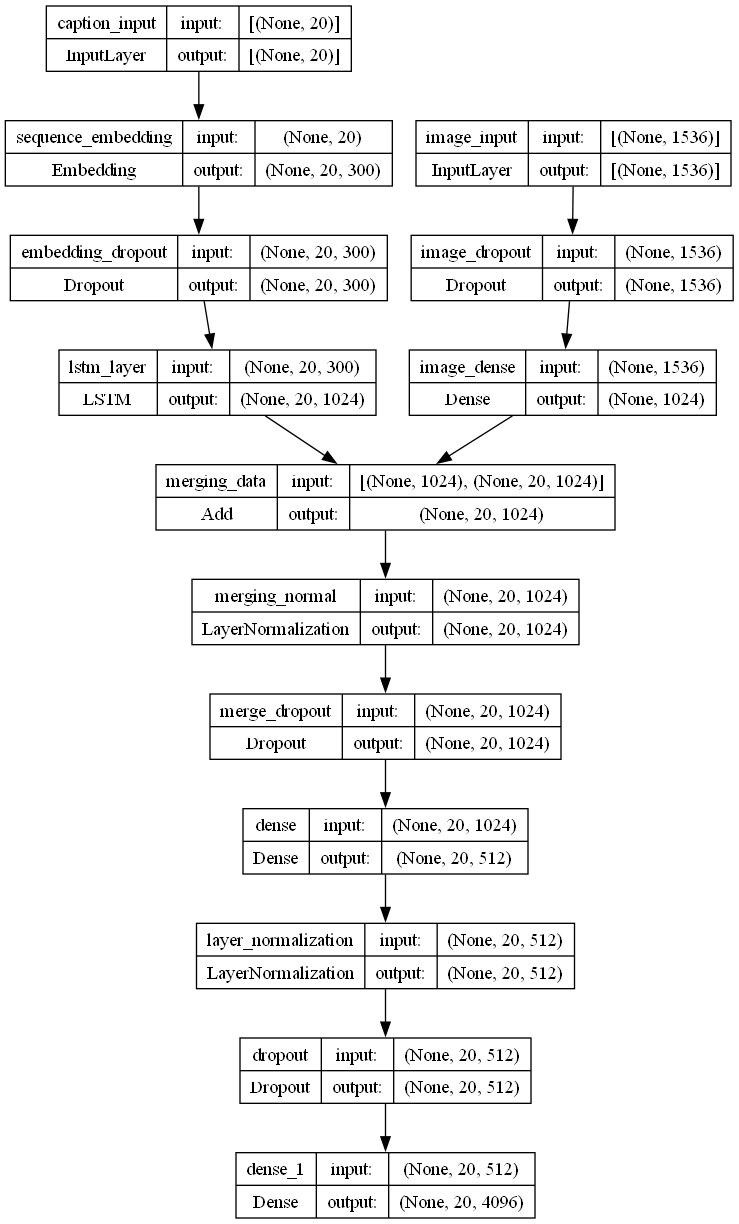

In [7]:
plot_model(model, show_shapes=True)

In [8]:
optimizer = Adam(LEARNING_RATE)

loss = SparseCategoricalCrossentropy()

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=1), 
    TensorBoard(
        log_dir='./tensorboard_logs/cnn_lstm_training',
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch')
]

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

training = model.fit(
    flicker_train_data,
    epochs=100,
    steps_per_epoch=FLICKER_STEPS,
    validation_data=flicker_val_data,
    validation_steps=FLICKER_VAL_STEPS,
    callbacks= callbacks,
    verbose=1
)

Epoch 1/100
59/59 [==============================] - 7s 54ms/step - loss: inf - accuracy: 0.4050 - val_loss: 3.4257 - val_accuracy: 0.4648
Epoch 2/100
59/59 [==============================] - 3s 48ms/step - loss: 3.2318 - accuracy: 0.4784 - val_loss: 3.0777 - val_accuracy: 0.4934
Epoch 3/100
59/59 [==============================] - 3s 48ms/step - loss: 3.0191 - accuracy: 0.5015 - val_loss: 2.9274 - val_accuracy: 0.5105
Epoch 4/100
59/59 [==============================] - 3s 47ms/step - loss: 2.8564 - accuracy: 0.5245 - val_loss: 2.7435 - val_accuracy: 0.5378
Epoch 5/100
59/59 [==============================] - 3s 45ms/step - loss: 2.6638 - accuracy: 0.5490 - val_loss: 2.5321 - val_accuracy: 0.5563
Epoch 6/100
59/59 [==============================] - 3s 46ms/step - loss: 2.4860 - accuracy: 0.5656 - val_loss: 2.4283 - val_accuracy: 0.5708
Epoch 7/100
59/59 [==============================] - 3s 47ms/step - loss: 2.3563 - accuracy: 0.5791 - val_loss: 2.2979 - val_accuracy: 0.5825
Epoch 8/1

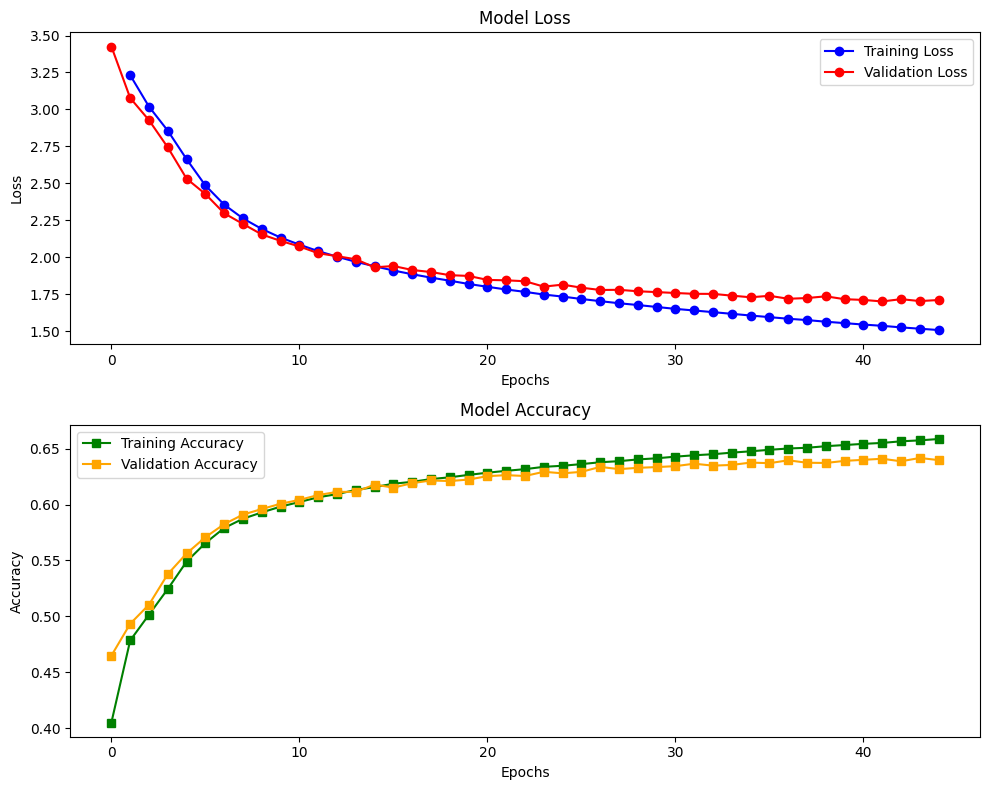

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotting Loss
axes[0].plot(training.history['loss'], marker='o', color='b', label='Training Loss')
axes[0].plot(training.history['val_loss'], marker='o', color='r', label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting Accuracy
axes[1].plot(training.history['accuracy'], marker='s', color='g', label='Training Accuracy')
axes[1].plot(training.history['val_accuracy'], marker='s', color='orange', label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

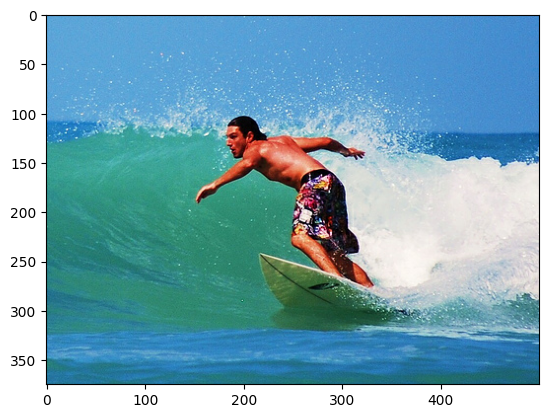

['a', 'man', 'in', 'a', 'wetsuit', 'is', 'surfing'] 

['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'surfing', 'on', 'a', 'wave'] 

['a', 'man', 'in', 'colorful', 'shorts', 'is', 'surfing', 'under', 'a', 'wave']
['a', 'man', 'in', 'colorful', 'trunks', 'surfing', 'a', 'wave', 'on', 'a', 'white', 'surfboard']
['a', 'surfer', 'rides', 'a', 'wave', 'in', 'a', 'clear', 'blue', 'ocean']
['a', 'surfer', 'surfs', 'a', 'wave']
['man', 'in', '[UNK]', 'trunks', 'riding', 'a', 'surfboard', 'on', 'a', 'wave']
0.5798969072164949 0.6657910689028086


In [10]:
test_image = choice(coco_val_images)
test_features = coco_val_feature_map[test_image]
target_captions = coco_val_caption_map[test_image]

display_image('datasets/coco/val2014/', test_image)
greedy, beam, true_captions = generate_and_evaluate_caption(model, test_features, target_captions, idx_to_word, SEQ_LENGTH)
print(greedy[0], '\n')
print(beam[0], '\n')

for caption in true_captions: 
    print(caption)
    
print(greedy[2], beam[2])

In [11]:
predicted_captions, true_captions = generate_captions(model, coco_val_images, coco_val_feature_map, coco_val_caption_map, idx_to_word, SEQ_LENGTH, 1024)
coco_validation_score_1 = evaluate_captions(predicted_captions, true_captions)
print(coco_validation_score_1)

([0.44426220413628936, 0.24636497635441743, 0.13945656175585852, 0.08760372312774756], 0.2917317022579204)


# Training model on COCO dataset

In [12]:

# optimizer = Adam(LEARNING_RATE)

# loss = SparseCategoricalCrossentropy()

# callbacks = [
#     EarlyStopping(
#         monitor='val_loss',
#         patience=3,
#         verbose=1), 
#     # TensorBoard(
#     #     log_dir='./tensorboard_logs/cnn_lstm_training',
#     #     histogram_freq=1,
#     #     write_graph=True,
#     #     update_freq='epoch')
# ]


# model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

training = model.fit(
    coco_train_data,
    epochs=100,
    steps_per_epoch=COCO_STEPS,
    validation_data=coco_val_data,
    validation_steps=COCO_VAL_STEPS,
    callbacks= callbacks,
    verbose=1
)

Epoch 1/100
809/809 [==============================] - 34s 41ms/step - loss: 1.7787 - accuracy: 0.6570 - val_loss: 1.5872 - val_accuracy: 0.6788
Epoch 2/100
809/809 [==============================] - 33s 40ms/step - loss: 1.6170 - accuracy: 0.6727 - val_loss: 1.5156 - val_accuracy: 0.6866
Epoch 3/100
809/809 [==============================] - 33s 40ms/step - loss: 1.5586 - accuracy: 0.6789 - val_loss: 1.4763 - val_accuracy: 0.6914
Epoch 4/100
809/809 [==============================] - 33s 40ms/step - loss: 1.5210 - accuracy: 0.6833 - val_loss: 1.4511 - val_accuracy: 0.6946
Epoch 5/100
809/809 [==============================] - 32s 40ms/step - loss: 1.4932 - accuracy: 0.6863 - val_loss: 1.4301 - val_accuracy: 0.6974
Epoch 6/100
809/809 [==============================] - 31s 39ms/step - loss: 1.4714 - accuracy: 0.6890 - val_loss: 1.4160 - val_accuracy: 0.6989
Epoch 7/100
809/809 [==============================] - 33s 41ms/step - loss: 1.4532 - accuracy: 0.6911 - val_loss: 1.4043 - val_ac

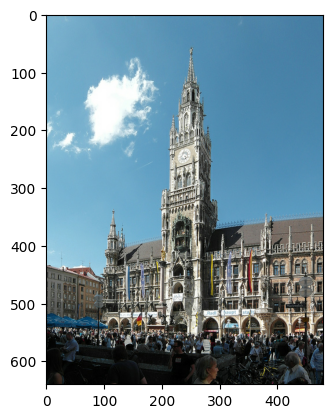

['a', 'large', 'building', 'with', 'a', 'clock', 'tower', 'on', 'top'] 

['a', 'large', 'clock', 'tower', 'towering', 'over', 'a', 'city'] 

['people', 'walking', 'by', 'a', 'tall', 'tower', 'on', 'a', 'large', 'building']
['a', 'tall', 'clock', 'tower', 'sitting', 'in', 'the', 'middle', 'of', 'a', 'building']
['large', 'clock', 'tower', 'attached', 'to', 'a', 'building', 'in', 'a', 'city']
['many', 'people', 'are', 'gathered', 'outside', 'of', 'a', 'large', 'building']
['people', 'fill', 'the', 'square', 'in', 'front', 'of', 'a', 'historical', 'building']
0.5162738496071829 0.5739795918367346


In [23]:
test_image = choice(coco_val_images)
test_features = coco_val_feature_map[test_image]
target_captions = coco_val_caption_map[test_image]

display_image('datasets/coco/val2014/', test_image)
greedy, beam, true_captions = generate_and_evaluate_caption(model, test_features, target_captions, idx_to_word, SEQ_LENGTH)
print(greedy[0], '\n')
print(beam[0], '\n')

for caption in true_captions: 
    print(caption)
    
print(greedy[2], beam[2])

In [14]:
predicted_captions, true_captions = generate_captions(model, coco_val_images, coco_val_feature_map, coco_val_caption_map, idx_to_word, SEQ_LENGTH, 1024)
coco_validation_score_2 = evaluate_captions(predicted_captions, true_captions)
print(coco_validation_score_2)

([0.6660431207006638, 0.4749824233243286, 0.32766915858043694, 0.23204559398455354], 0.4323850472701335)


## Training outputs 
1. ([0.6405022734089714, 0.4463027082229372, 0.29934462206575563, 0.20871405332039702], 0.4145237453375769) v1
2. ([0.6418743284682035, 0.442693660623719, 0.29415405024196956, 0.20058639500348188], 0.4080181609786798) v2


- ([0.6211531810024086, 0.410840029257982, 0.26646794915971794, 0.1811533502178472], 0.38122496568020725) batch = 64
- ([0.5993318816719131,
  0.3865770367462274,
  0.24482775805037613,
  0.16440581561248588],
 0.3609836026638695) batch = 32
 - ([0.6344307633588684,
  0.4343686956410259,
  0.28711750048084483,
  0.19787981935572438],
 0.3971223813690533) batch = 256
- ([0.6298820729985007,
  0.4312138237301613,
  0.2866155554360642,
  0.19793620298236123],
 0.39902906753744116) previous with more training 
 - ([0.6428814404792379,
  0.4456909514391105,
  0.29858524736881525,
  0.2072303796603672],
 0.4091058296690576) batch = 256, 20 epochs, model saved
 - ([0.6428814404792379,
  0.4456909514391105,
  0.29858524736881525,
  0.2072303796603672],
 0.4091058296690576) previous model with more training 
 - ([0.6390607878281732,
  0.4406290889734613,
  0.2962323225086467,
  0.2063178068601112],
 0.40974129391739644) changed hid dim to 512
 - ([0.6568510950992849,
  0.46559990385495154,
  0.3192417928203884,
  0.22491635004582852],
 0.42799321255907147) added dense layer after concat 
- ([0.6587281145210543, 0.46645935795158766, 0.3197388747860869, 0.22476968676484035], 0.4291688430643734) new model architecture 
- ([0.6675137540187852, 0.47665026274599326, 0.32936394909066596, 0.23312716552151663], 0.43739000166942277) lowered learning rate
-([0.6687834031781694, 0.4770955620304046, 0.32960422710522647, 0.2337679395681262], 0.4379029402568347) retrained



In [24]:
model.save('saved_models/lstm_decoder.keras')